# Modelos de Machine Learning

Este notebook implementa y compara modelos avanzados de machine learning de los que nos hemos basado en árboles de decisión:

1. **Random Forest** - Ensamble de árboles de decisión
2. **XGBoost** - Gradient boosting extremo
3. **LightGBM** - Gradient boosting eficiente
4. **CatBoost** - Gradient boosting con manejo nativo de categóricas

Se utilizarán pipelines de sklearn para reproducibilidad y se optimizarán hiperparámetros con búsqueda limitada para mantener tiempo <10 min.

In [1]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import json
import joblib
import time
import shutil

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Gradient Boosting models
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

warnings.filterwarnings('ignore')

# Configuración
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('default')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [14, 6]

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Configuración de Fechas de Entrenamiento

Define el rango de fechas para entrenamiento.

**Nota**: Estos valores pueden ser sobrescritos por el Notebook 00 (Pipeline Maestro) cuando se ejecuta automáticamente.

In [2]:
# PARÁMETROS - Esta celda puede ser sobrescrita por papermill (NB00)
# Si ejecutas este notebook manualmente, modifica estos valores aquí
# Si lo ejecutas desde NB00, estos valores serán reemplazados automáticamente

# Configuración de fechas de entrenamiento
# None = usar todos los datos disponibles desde el inicio
FECHA_INICIO_ENTRENAMIENTO = None
# Por defecto: hasta el 2025-09-20 (puedes cambiarlo según necesites)
FECHA_FIN_ENTRENAMIENTO = pd.Timestamp('2025-09-20 23:59:59')

In [3]:
# Mostrar configuración activa
print("="*80)
print("CONFIGURACIÓN DE FECHAS ACTIVA (NB05 - Tree-Based Models)")
print("="*80)
print(f"Inicio: {'Desde el principio' if FECHA_INICIO_ENTRENAMIENTO is None else FECHA_INICIO_ENTRENAMIENTO}")
print(f"Fin:    {FECHA_FIN_ENTRENAMIENTO}")
print("="*80)

CONFIGURACIÓN DE FECHAS ACTIVA (NB05 - Tree-Based Models)
Inicio: Desde el principio
Fin:    2025-09-20 23:59:59


## Carga de Datos y Features Seleccionadas

In [4]:
# Cargar datos de entrenamiento
df = pd.read_parquet('artifacts/data/train_models/features_train.parquet')

# Aplicar filtros de fecha si están configurados
if FECHA_INICIO_ENTRENAMIENTO is not None:
    df = df[df['datetime'] >= FECHA_INICIO_ENTRENAMIENTO]
    print(f"Aplicando filtro: datos desde {FECHA_INICIO_ENTRENAMIENTO}")
    
if FECHA_FIN_ENTRENAMIENTO is not None:
    df = df[df['datetime'] <= FECHA_FIN_ENTRENAMIENTO]
    print(f"Aplicando filtro: datos hasta {FECHA_FIN_ENTRENAMIENTO}")

# Cargar features seleccionadas del análisis exploratorio
with open('artifacts/analysis/selected_features.json', 'r') as f:
    selected_features_data = json.load(f)
    selected_features = selected_features_data['features']

print(f"\nDataset cargado:")
print(f"  Total registros: {len(df):,}")
print(f"  Período: {df['datetime'].min()} a {df['datetime'].max()}")
print(f"  Features seleccionadas: {len(selected_features)}")
print(f"\nPrimeras 10 features: {selected_features[:10]}")

Aplicando filtro: datos hasta 2025-09-20 23:59:59

Dataset cargado:
  Total registros: 23,856
  Período: 2023-01-01 00:00:00 a 2025-09-20 23:00:00
  Features seleccionadas: 29

Primeras 10 features: ['lag_1h', 'lag_168h', 'lag_24h', 'hora_del_dia', 'hora_del_dia_cos', 'media_movil_12h', 'media_movil_24h', 'media_movil_6h', 'hora_del_dia_sin', 'lag_48h']


## Preparación de Datos

In [5]:
# Definir fecha de corte para train/test (últimos 2 meses para test)
fecha_corte = df['datetime'].max() - pd.DateOffset(months=2)

# Separar en train y test
df_train = df[df['datetime'] < fecha_corte].copy()
df_test = df[df['datetime'] >= fecha_corte].copy()

print(f"División train/test:")
print(f"  Train: {len(df_train):,} registros ({df_train['datetime'].min()} a {df_train['datetime'].max()})")
print(f"  Test:  {len(df_test):,} registros ({df_test['datetime'].min()} a {df_test['datetime'].max()})")

# Preparar X e y
# Filtrar solo features que existen en el dataframe
available_features = [f for f in selected_features if f in df.columns]
print(f"\nFeatures disponibles de las seleccionadas: {len(available_features)}/{len(selected_features)}")

# Eliminar NaN (incluir datetime para guardarlo después)
df_train_clean = df_train[available_features + ['demanda', 'datetime']].dropna()
df_test_clean = df_test[available_features + ['demanda', 'datetime']].dropna()

X_train = df_train_clean[available_features]
y_train = df_train_clean['demanda']
X_test = df_test_clean[available_features]
y_test = df_test_clean['demanda']

print(f"\nDatos limpios:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")

División train/test:
  Train: 22,367 registros (2023-01-01 00:00:00 a 2025-07-20 22:00:00)
  Test:  1,489 registros (2025-07-20 23:00:00 a 2025-09-20 23:00:00)

Features disponibles de las seleccionadas: 29/29

Datos limpios:
  X_train: (22151, 29)
  X_test: (1489, 29)


## Función de Evaluación

In [6]:
def evaluar_modelo(y_true, y_pred, nombre_modelo="", tiempo_entrenamiento=None):
    """
    Evalúa el rendimiento de un modelo usando múltiples métricas.
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{'='*60}")
    print(f"Resultados: {nombre_modelo}")
    print(f"{'='*60}")
    print(f"MAE:  {mae:,.2f} MW")
    print(f"RMSE: {rmse:,.2f} MW")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²:   {r2:.4f}")
    if tiempo_entrenamiento:
        print(f"Tiempo de entrenamiento: {tiempo_entrenamiento:.2f} segundos")
    print(f"{'='*60}")
    
    return {
        'modelo': nombre_modelo,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'r2': r2,
        'tiempo_entrenamiento': tiempo_entrenamiento
    }

def plot_predictions(y_true, y_pred, title="", n_samples=168):
    """
    Visualiza predicciones vs valores reales (primera semana).
    """
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Predicciones vs Real
    axes[0].plot(y_true[:n_samples].values, label='Real', linewidth=2)
    axes[0].plot(y_pred[:n_samples], label='Predicción', linestyle='--', linewidth=2)
    axes[0].set_title(f'{title} - Primera Semana')
    axes[0].set_xlabel('Horas')
    axes[0].set_ylabel('Demanda (MW)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Errores
    errors = y_true[:n_samples].values - y_pred[:n_samples]
    axes[1].plot(errors, color='red', linewidth=1.5)
    axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1].fill_between(range(len(errors)), errors, alpha=0.3, color='red')
    axes[1].set_title('Error de Predicción')
    axes[1].set_xlabel('Horas')
    axes[1].set_ylabel('Error (MW)')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Lista para almacenar resultados
resultados_modelos = []

## 1. Random Forest


ENTRENANDO RANDOM FOREST
✓ Modelo entrenado en 0.65 segundos

Rendimiento en TRAIN:

Resultados: Random Forest (Train)
MAE:  260.95 MW
RMSE: 368.03 MW
MAPE: 0.92%
R²:   0.9934

Rendimiento en TEST:

Resultados: Random Forest (Test)
MAE:  343.64 MW
RMSE: 461.93 MW
MAPE: 1.14%
R²:   0.9854
Tiempo de entrenamiento: 0.65 segundos
✓ Modelo entrenado en 0.65 segundos

Rendimiento en TRAIN:

Resultados: Random Forest (Train)
MAE:  260.95 MW
RMSE: 368.03 MW
MAPE: 0.92%
R²:   0.9934

Rendimiento en TEST:

Resultados: Random Forest (Test)
MAE:  343.64 MW
RMSE: 461.93 MW
MAPE: 1.14%
R²:   0.9854
Tiempo de entrenamiento: 0.65 segundos


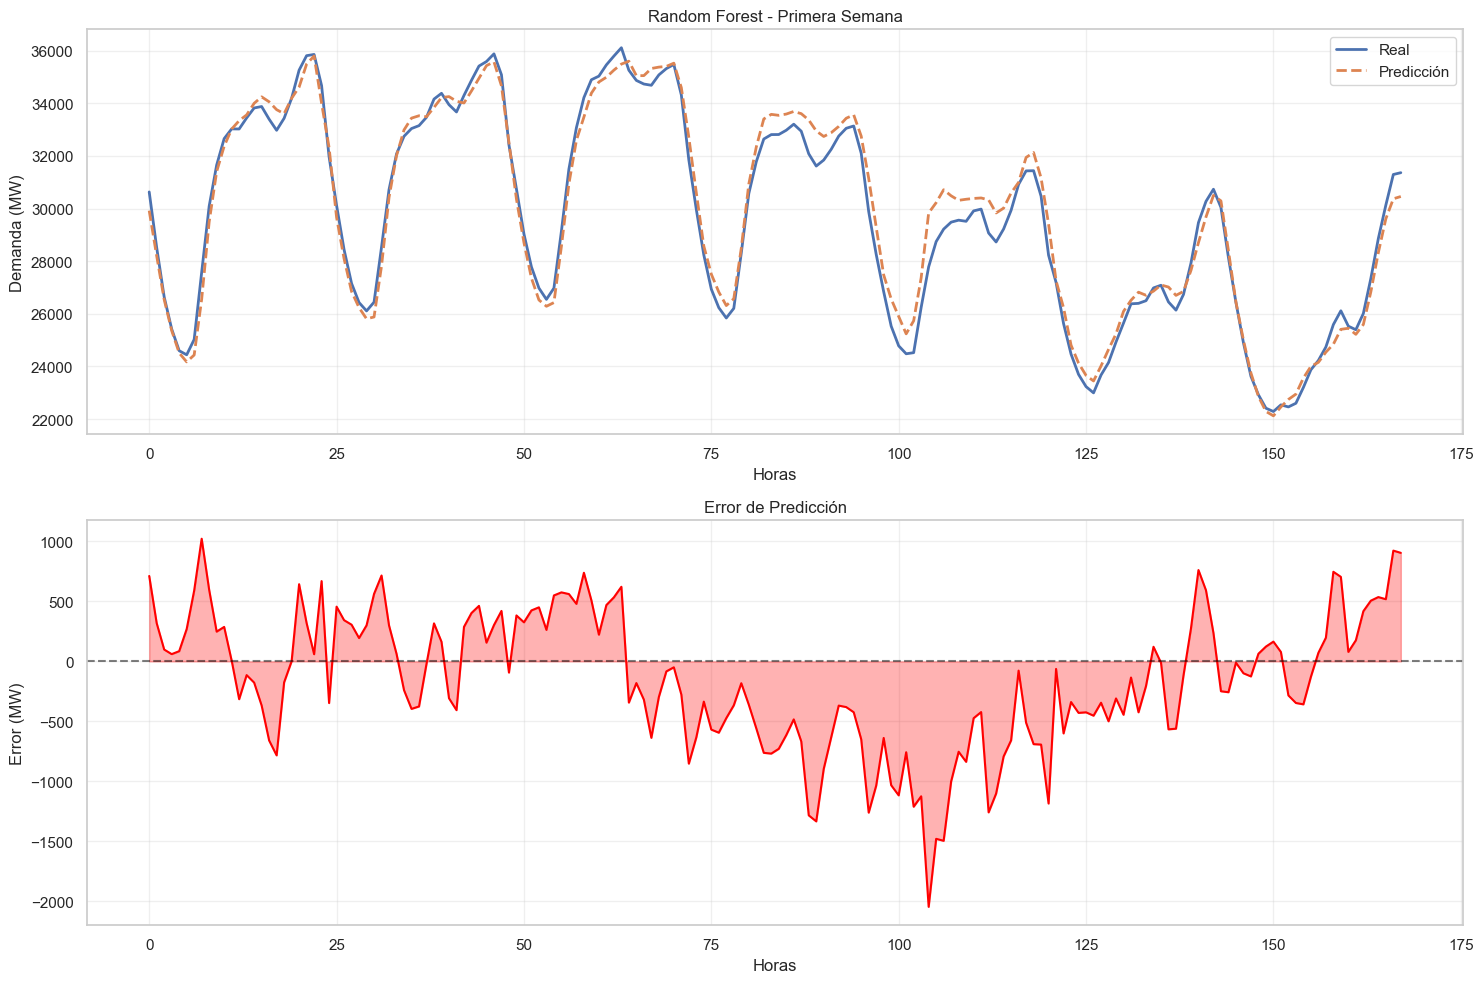

In [7]:
print("\n" + "="*60)
print("ENTRENANDO RANDOM FOREST")
print("="*60)

# Crear pipeline
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        min_samples_split=20,
        min_samples_leaf=10,
        max_features='sqrt',
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=0
    ))
])

# Entrenar
start_time = time.time()
rf_pipeline.fit(X_train, y_train)
rf_train_time = time.time() - start_time

print(f"✓ Modelo entrenado en {rf_train_time:.2f} segundos")

# Predicciones
rf_pred_train = rf_pipeline.predict(X_train)
rf_pred_test = rf_pipeline.predict(X_test)

# Evaluar
print("\nRendimiento en TRAIN:")
rf_results_train = evaluar_modelo(y_train, rf_pred_train, "Random Forest (Train)")

print("\nRendimiento en TEST:")
rf_results_test = evaluar_modelo(y_test, rf_pred_test, "Random Forest (Test)", rf_train_time)
resultados_modelos.append(rf_results_test)

# Visualizar
plot_predictions(y_test, rf_pred_test, "Random Forest")


Top 20 Features más importantes (Random Forest):


,feature,importance
0,lag_1h,0.226
1,lag_168h,0.173
2,lag_24h,0.119
7,media_movil_6h,0.109
3,hora_del_dia,0.076
9,lag_48h,0.047
6,media_movil_24h,0.043
5,media_movil_12h,0.040
10,price,0.029
4,hora_del_dia_cos,0.026


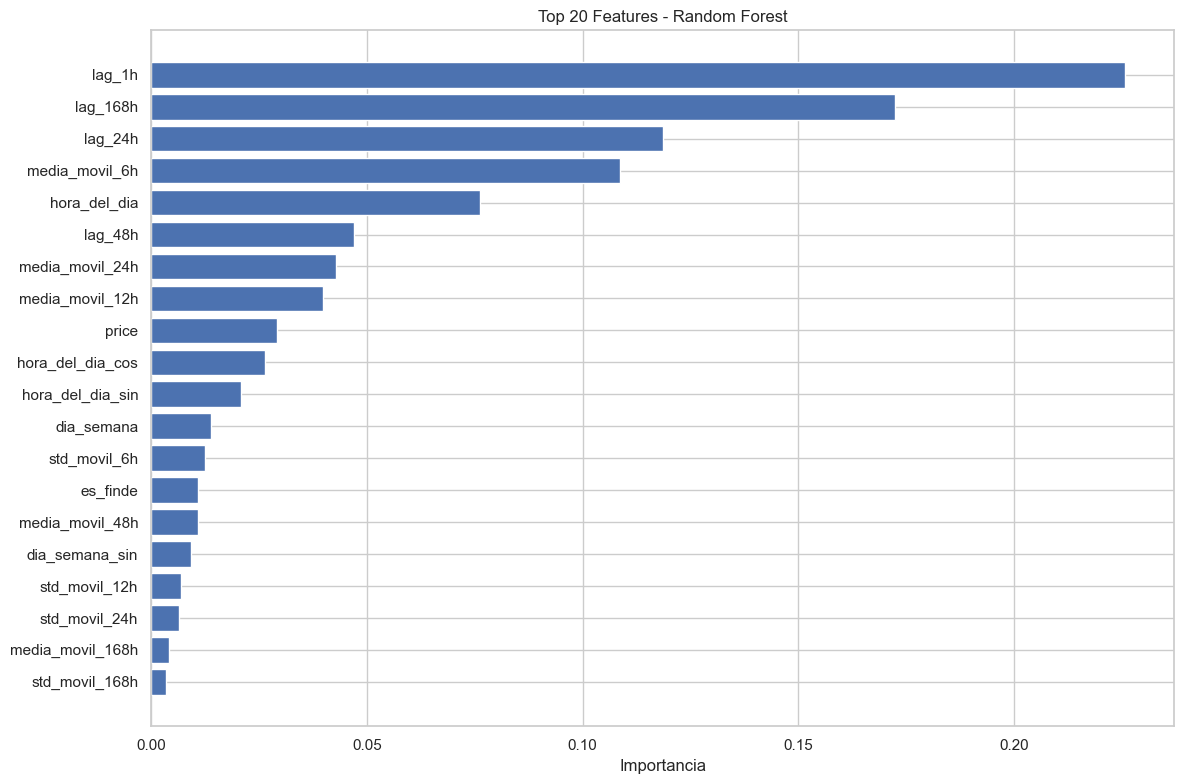

In [8]:
# Feature importance de Random Forest
rf_model = rf_pipeline.named_steps['model']
rf_importance = pd.DataFrame({
    'feature': available_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Features más importantes (Random Forest):")
display(rf_importance.head(20))

# Visualizar
plt.figure(figsize=(12, 8))
top_20 = rf_importance.head(20)
plt.barh(range(len(top_20)), top_20['importance'])
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Importancia')
plt.title('Top 20 Features - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 2. XGBoost


ENTRENANDO XGBOOST
✓ Modelo entrenado en 0.64 segundos

Rendimiento en TRAIN:

Resultados: XGBoost (Train)
MAE:  118.41 MW
RMSE: 155.02 MW
MAPE: 0.42%
R²:   0.9988

Rendimiento en TEST:

Resultados: XGBoost (Test)
MAE:  217.83 MW
RMSE: 290.08 MW
MAPE: 0.72%
R²:   0.9942
Tiempo de entrenamiento: 0.64 segundos


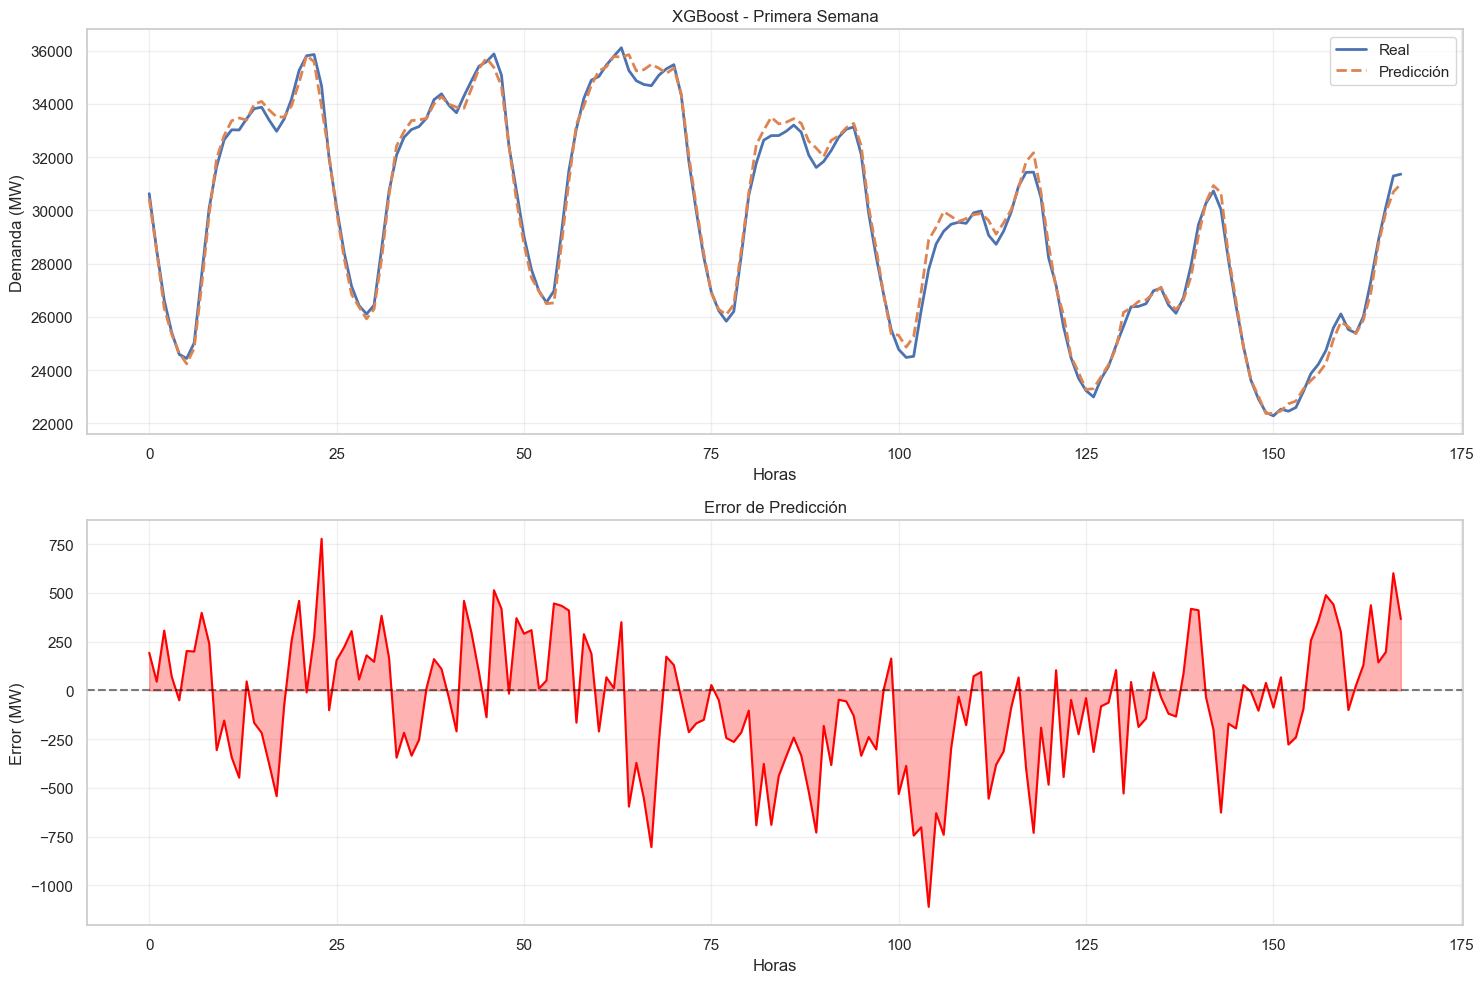

In [9]:
print("\n" + "="*60)
print("ENTRENANDO XGBOOST")
print("="*60)

# Crear pipeline
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', xgb.XGBRegressor(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=3,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1.0,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        tree_method='hist',
        verbosity=0
    ))
])

# Entrenar
start_time = time.time()
xgb_pipeline.fit(X_train, y_train)
xgb_train_time = time.time() - start_time

print(f"✓ Modelo entrenado en {xgb_train_time:.2f} segundos")

# Predicciones
xgb_pred_train = xgb_pipeline.predict(X_train)
xgb_pred_test = xgb_pipeline.predict(X_test)

# Evaluar
print("\nRendimiento en TRAIN:")
xgb_results_train = evaluar_modelo(y_train, xgb_pred_train, "XGBoost (Train)")

print("\nRendimiento en TEST:")
xgb_results_test = evaluar_modelo(y_test, xgb_pred_test, "XGBoost (Test)", xgb_train_time)
resultados_modelos.append(xgb_results_test)

# Visualizar
plot_predictions(y_test, xgb_pred_test, "XGBoost")


Top 20 Features más importantes (XGBoost):


,feature,importance
0,lag_1h,0.476
1,lag_168h,0.139
24,es_finde,0.069
17,es_hora_pico_mañana,0.068
2,lag_24h,0.063
4,hora_del_dia_cos,0.046
7,media_movil_6h,0.043
27,es_festivo,0.016
15,es_hora_pico_tarde,0.014
5,media_movil_12h,0.010


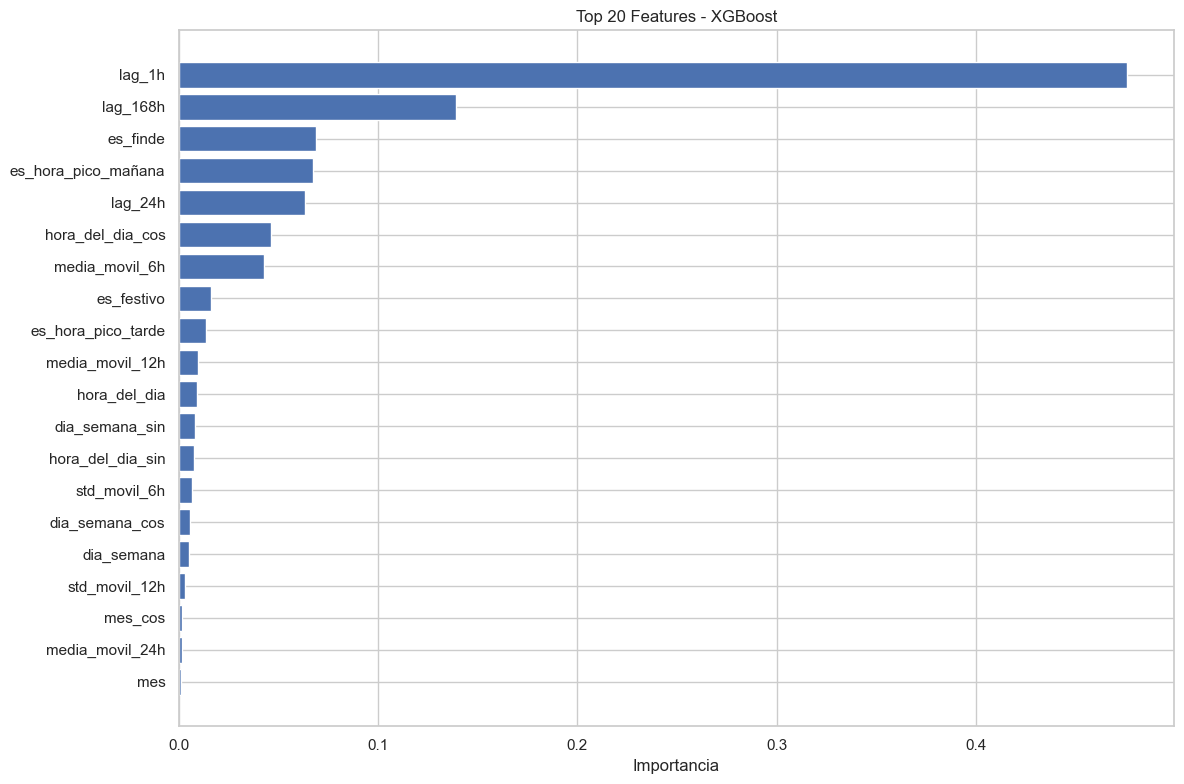

In [10]:
# Feature importance de XGBoost
xgb_model = xgb_pipeline.named_steps['model']
xgb_importance = pd.DataFrame({
    'feature': available_features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Features más importantes (XGBoost):")
display(xgb_importance.head(20))

# Visualizar
plt.figure(figsize=(12, 8))
top_20 = xgb_importance.head(20)
plt.barh(range(len(top_20)), top_20['importance'])
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Importancia')
plt.title('Top 20 Features - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 3. LightGBM


ENTRENANDO LIGHTGBM
Modelo entrenado en 1.06 segundos

Rendimiento en TRAIN:

Resultados: LightGBM (Train)
MAE:  206.62 MW
RMSE: 273.04 MW
MAPE: 0.73%
R²:   0.9964

Rendimiento en TEST:

Resultados: LightGBM (Test)
MAE:  259.78 MW
RMSE: 339.54 MW
MAPE: 0.87%
R²:   0.9921
Tiempo de entrenamiento: 1.06 segundos


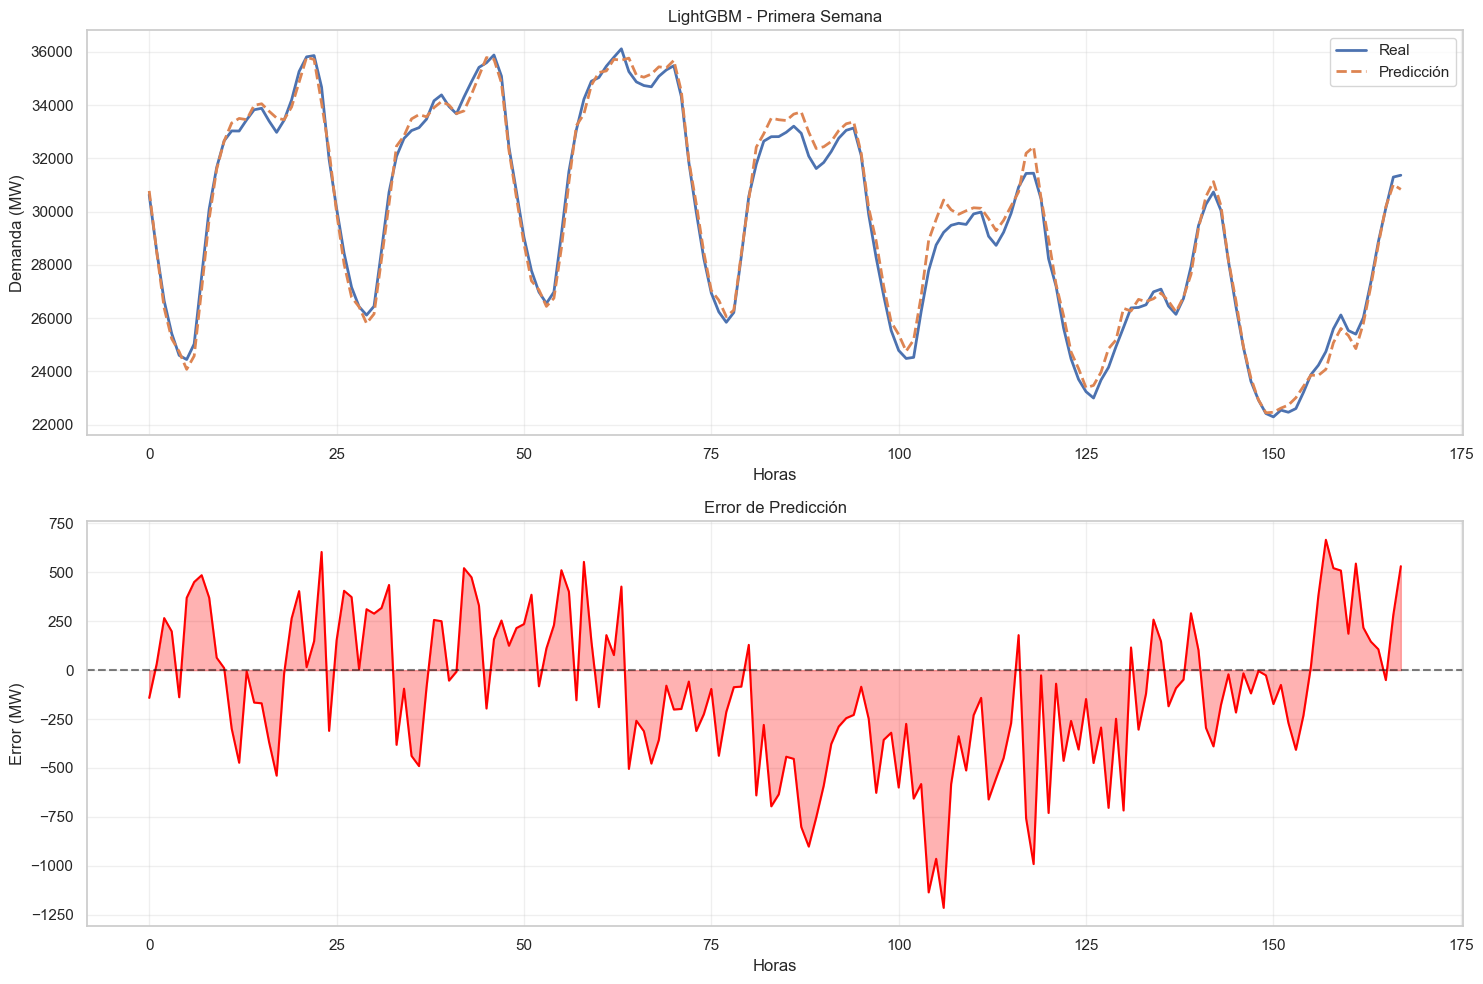

In [11]:
print("\n" + "="*60)
print("ENTRENANDO LIGHTGBM")
print("="*60)

# Crear pipeline
lgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', lgb.LGBMRegressor(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_samples=20,
        reg_alpha=0.1,
        reg_lambda=1.0,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=-1
    ))
])

# Entrenar
start_time = time.time()
lgb_pipeline.fit(X_train, y_train)
lgb_train_time = time.time() - start_time

print(f"Modelo entrenado en {lgb_train_time:.2f} segundos")

# Predicciones
lgb_pred_train = lgb_pipeline.predict(X_train)
lgb_pred_test = lgb_pipeline.predict(X_test)

# Evaluar
print("\nRendimiento en TRAIN:")
lgb_results_train = evaluar_modelo(y_train, lgb_pred_train, "LightGBM (Train)")

print("\nRendimiento en TEST:")
lgb_results_test = evaluar_modelo(y_test, lgb_pred_test, "LightGBM (Test)", lgb_train_time)
resultados_modelos.append(lgb_results_test)

# Visualizar
plot_predictions(y_test, lgb_pred_test, "LightGBM")


Top 20 Features más importantes (LightGBM):


,feature,importance
0,lag_1h,800
3,hora_del_dia,627
13,std_movil_6h,573
4,hora_del_dia_cos,448
8,hora_del_dia_sin,422
1,lag_168h,300
21,mes_cos,254
2,lag_24h,233
19,dia_semana,228
16,mes,215


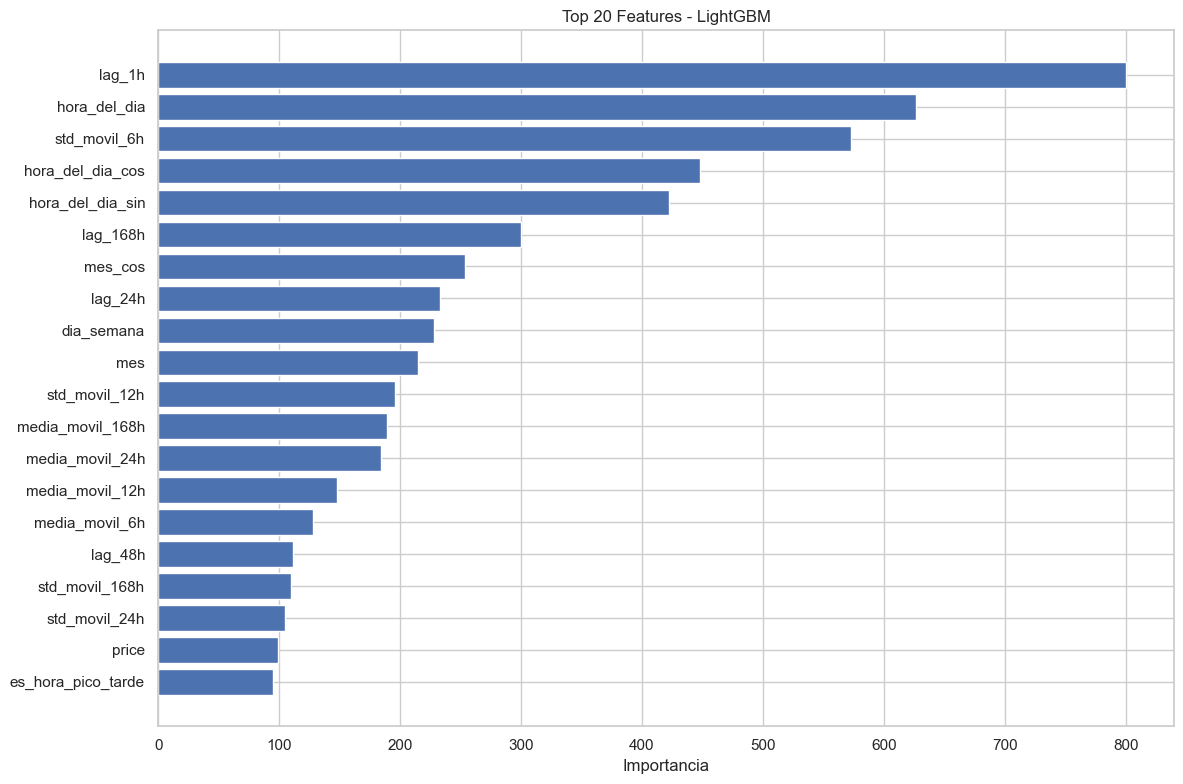

In [12]:
# Feature importance de LightGBM
lgb_model = lgb_pipeline.named_steps['model']
lgb_importance = pd.DataFrame({
    'feature': available_features,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Features más importantes (LightGBM):")
display(lgb_importance.head(20))

# Visualizar
plt.figure(figsize=(12, 8))
top_20 = lgb_importance.head(20)
plt.barh(range(len(top_20)), top_20['importance'])
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Importancia')
plt.title('Top 20 Features - LightGBM')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 4. CatBoost


ENTRENANDO CATBOOST
✓ Modelo entrenado en 0.61 segundos

Rendimiento en TRAIN:

Resultados: CatBoost (Train)
MAE:  236.17 MW
RMSE: 310.80 MW
MAPE: 0.84%
R²:   0.9953

Rendimiento en TEST:

Resultados: CatBoost (Test)
MAE:  264.40 MW
RMSE: 334.97 MW
MAPE: 0.89%
R²:   0.9923
Tiempo de entrenamiento: 0.61 segundos


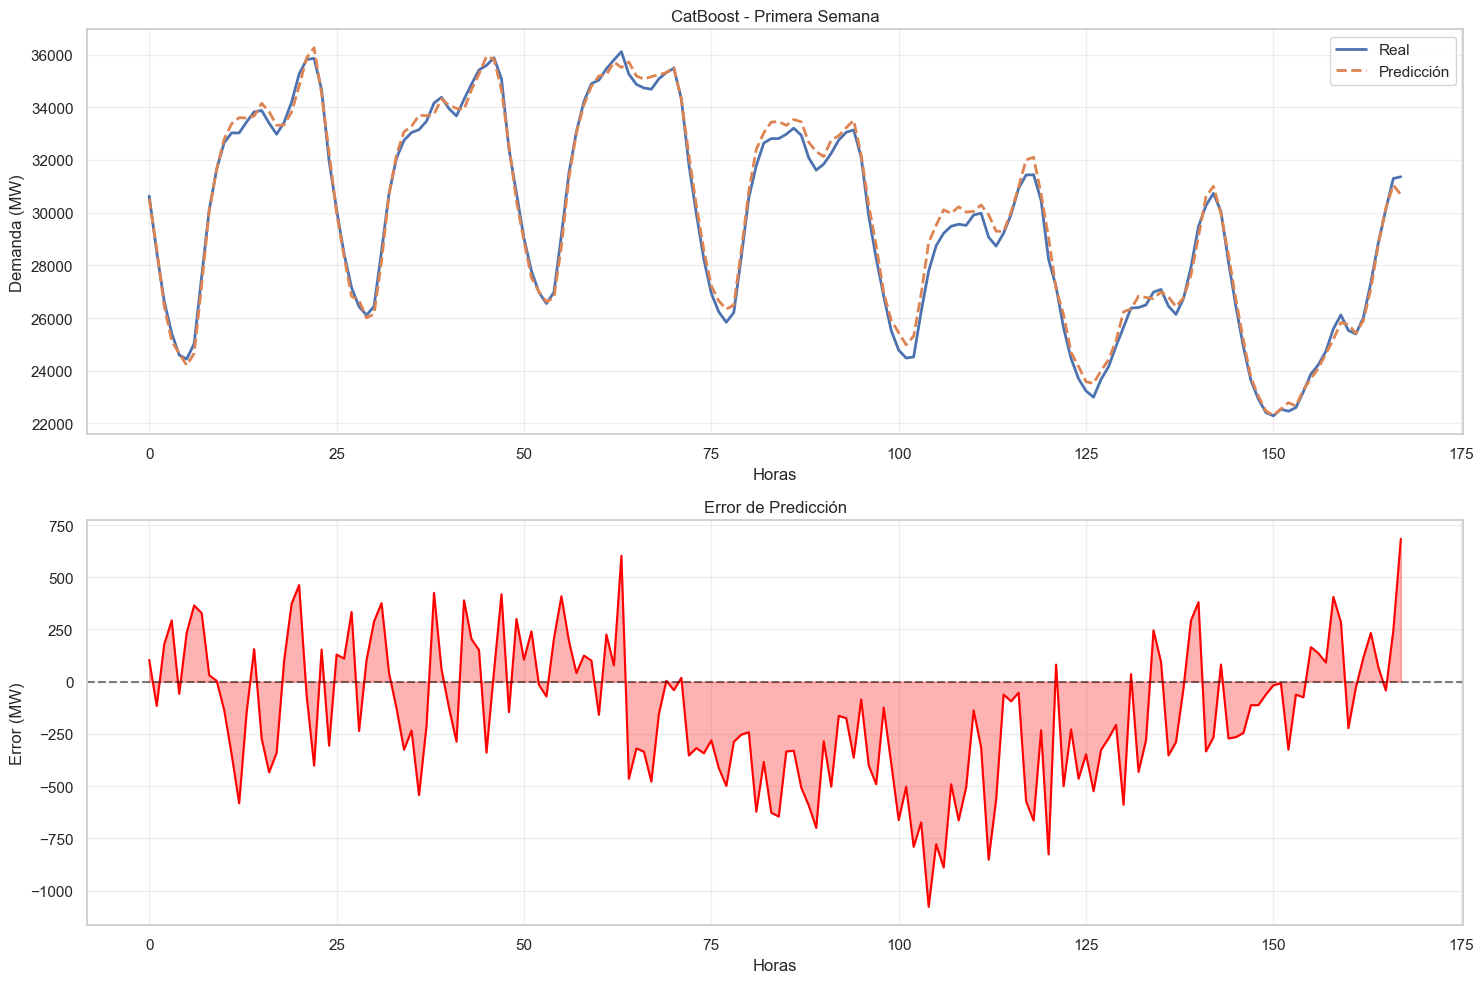

In [13]:
print("\n" + "="*60)
print("ENTRENANDO CATBOOST")
print("="*60)

# Crear pipeline
cat_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', CatBoostRegressor(
        iterations=200,
        depth=8,
        learning_rate=0.05,
        l2_leaf_reg=3.0,
        random_seed=RANDOM_STATE,
        verbose=False,
        thread_count=-1,
        train_dir=None
    ))
])

# Entrenar
start_time = time.time()
cat_pipeline.fit(X_train, y_train)
cat_train_time = time.time() - start_time

print(f"✓ Modelo entrenado en {cat_train_time:.2f} segundos")

# Predicciones
cat_pred_train = cat_pipeline.predict(X_train)
cat_pred_test = cat_pipeline.predict(X_test)

# Evaluar
print("\nRendimiento en TRAIN:")
cat_results_train = evaluar_modelo(y_train, cat_pred_train, "CatBoost (Train)")

print("\nRendimiento en TEST:")
cat_results_test = evaluar_modelo(y_test, cat_pred_test, "CatBoost (Test)", cat_train_time)
resultados_modelos.append(cat_results_test)

# Visualizar
plot_predictions(y_test, cat_pred_test, "CatBoost")


Top 20 Features más importantes (CatBoost):


,feature,importance
0,lag_1h,59.034
4,hora_del_dia_cos,10.562
1,lag_168h,7.967
3,hora_del_dia,3.326
8,hora_del_dia_sin,3.209
13,std_movil_6h,1.908
17,es_hora_pico_mañana,1.901
2,lag_24h,1.767
5,media_movil_12h,1.428
6,media_movil_24h,1.406


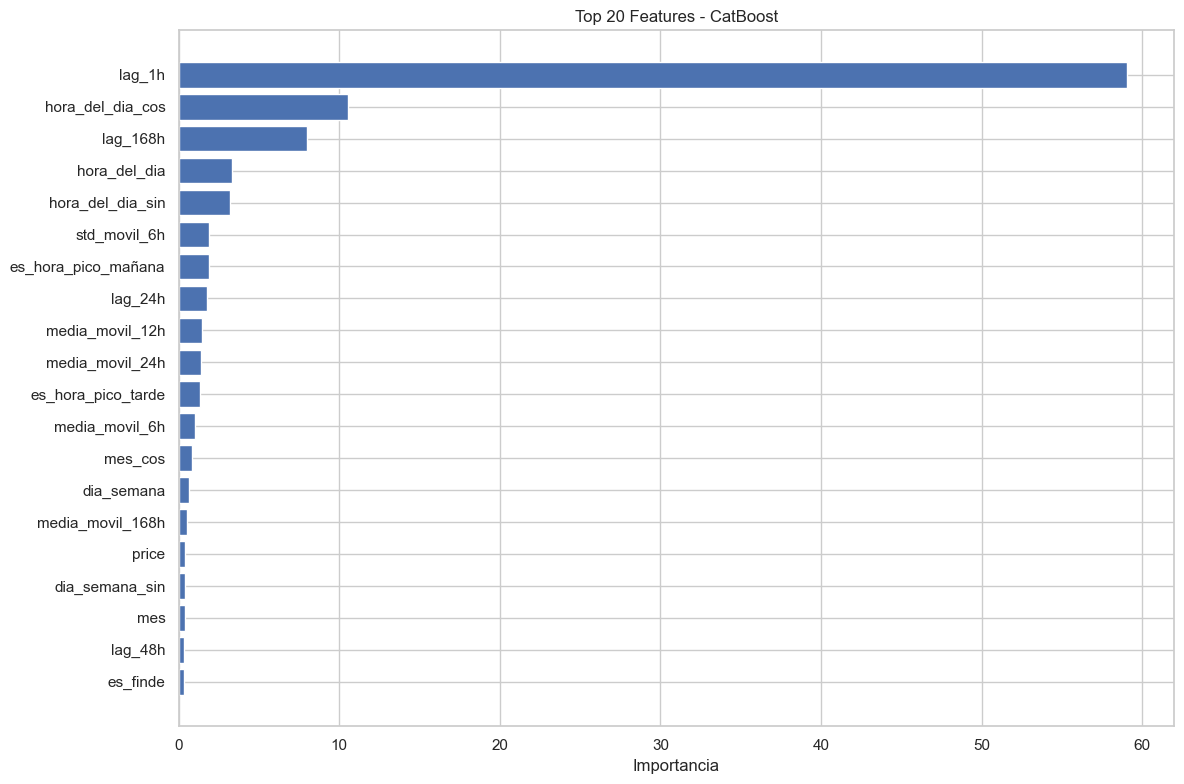

In [14]:
# Feature importance de CatBoost
cat_model = cat_pipeline.named_steps['model']
cat_importance = pd.DataFrame({
    'feature': available_features,
    'importance': cat_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Features más importantes (CatBoost):")
display(cat_importance.head(20))

# Visualizar
plt.figure(figsize=(12, 8))
top_20 = cat_importance.head(20)
plt.barh(range(len(top_20)), top_20['importance'])
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Importancia')
plt.title('Top 20 Features - CatBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Comparación de Modelos Basados en Árboles

In [15]:
# Crear DataFrame con resultados
resultados_df = pd.DataFrame(resultados_modelos)

print("\n" + "="*80)
print("COMPARACIÓN DE MODELOS BASADOS EN ÁRBOLES")
print("="*80)
display(resultados_df)

# Encontrar mejor modelo por cada métrica
print("\nMejor modelo por métrica:")
print(f"  Menor MAE:  {resultados_df.loc[resultados_df['mae'].idxmin(), 'modelo']} ({resultados_df['mae'].min():.2f} MW)")
print(f"  Menor RMSE: {resultados_df.loc[resultados_df['rmse'].idxmin(), 'modelo']} ({resultados_df['rmse'].min():.2f} MW)")
print(f"  Menor MAPE: {resultados_df.loc[resultados_df['mape'].idxmin(), 'modelo']} ({resultados_df['mape'].min():.2f}%)")
print(f"  Mayor R²:   {resultados_df.loc[resultados_df['r2'].idxmax(), 'modelo']} ({resultados_df['r2'].max():.4f})")
print(f"  Más rápido: {resultados_df.loc[resultados_df['tiempo_entrenamiento'].idxmin(), 'modelo']} ({resultados_df['tiempo_entrenamiento'].min():.2f}s)")


COMPARACIÓN DE MODELOS BASADOS EN ÁRBOLES


,modelo,mae,rmse,mape,r2,tiempo_entrenamiento
0,Random Forest (Test),343.638,461.932,1.144,0.985,0.654
1,XGBoost (Test),217.835,290.080,0.725,0.994,0.643
2,LightGBM (Test),259.779,339.541,0.870,0.992,1.057
3,CatBoost (Test),264.402,334.966,0.885,0.992,0.609



Mejor modelo por métrica:
  Menor MAE:  XGBoost (Test) (217.83 MW)
  Menor RMSE: XGBoost (Test) (290.08 MW)
  Menor MAPE: XGBoost (Test) (0.72%)
  Mayor R²:   XGBoost (Test) (0.9942)
  Más rápido: CatBoost (Test) (0.61s)


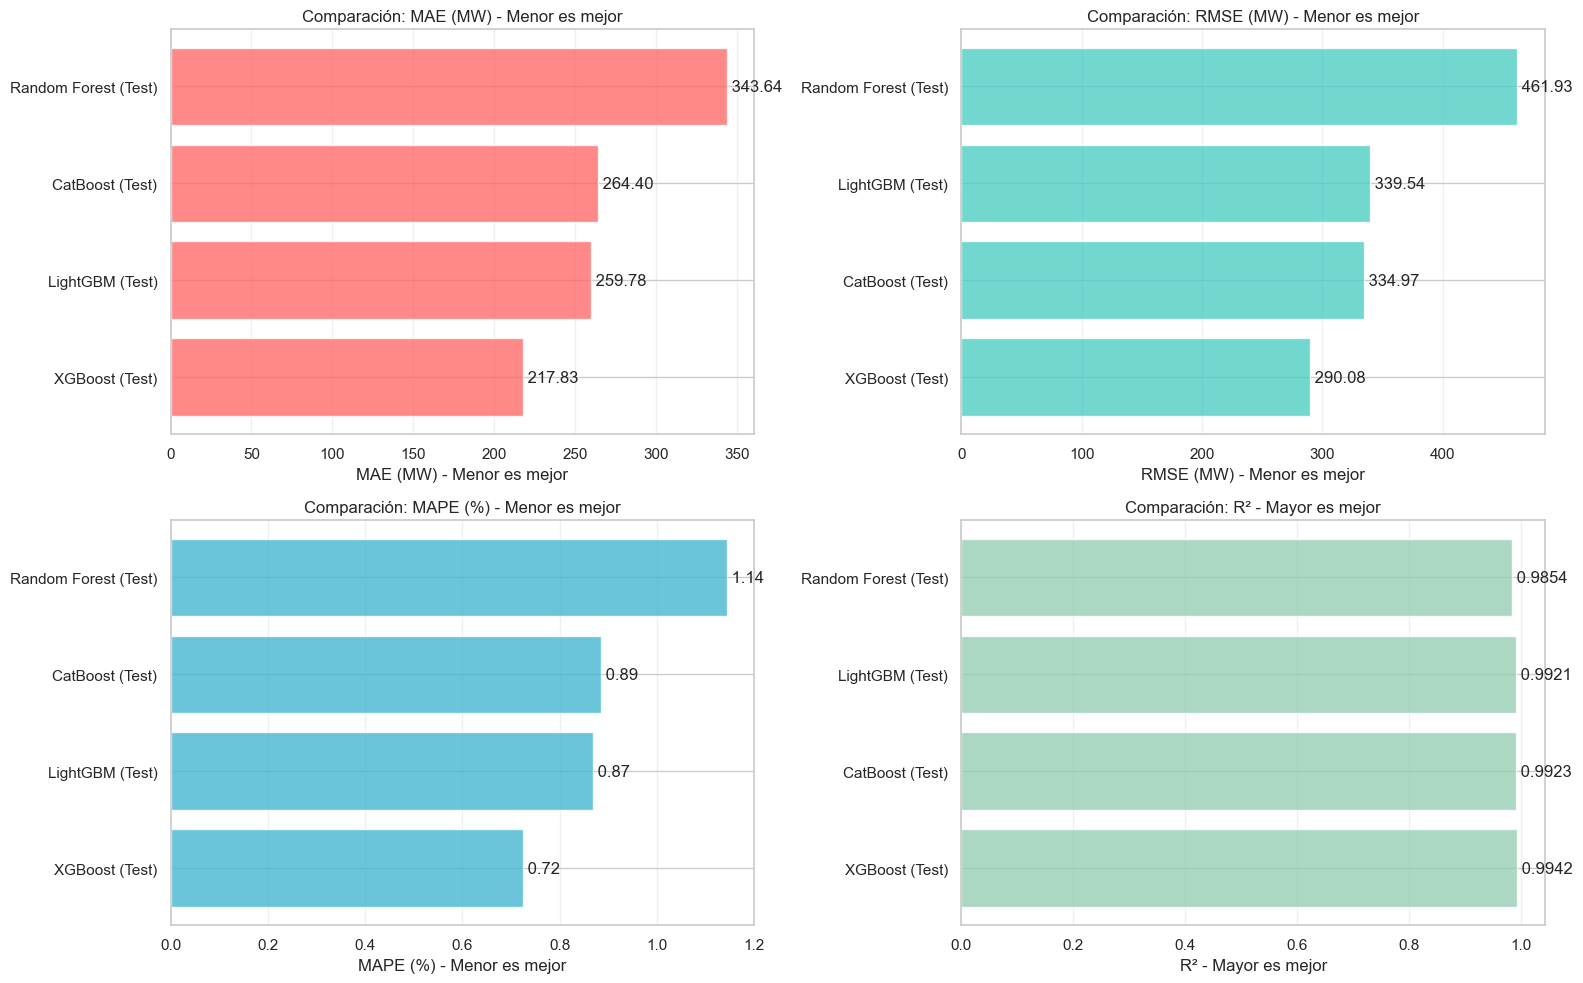

In [16]:
# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

metrics = ['mae', 'rmse', 'mape', 'r2']
titles = ['MAE (MW) - Menor es mejor', 'RMSE (MW) - Menor es mejor', 
          'MAPE (%) - Menor es mejor', 'R² - Mayor es mejor']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

for idx, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    ax = axes[idx // 2, idx % 2]
    data = resultados_df.sort_values(metric, ascending=(metric != 'r2'))
    ax.barh(data['modelo'], data[metric], color=color, alpha=0.8)
    ax.set_xlabel(title)
    ax.set_title(f'Comparación: {title}')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Añadir valores en las barras
    for i, v in enumerate(data[metric]):
        if metric == 'r2':
            ax.text(v, i, f' {v:.4f}', va='center')
        else:
            ax.text(v, i, f' {v:.2f}', va='center')

plt.tight_layout()
plt.show()

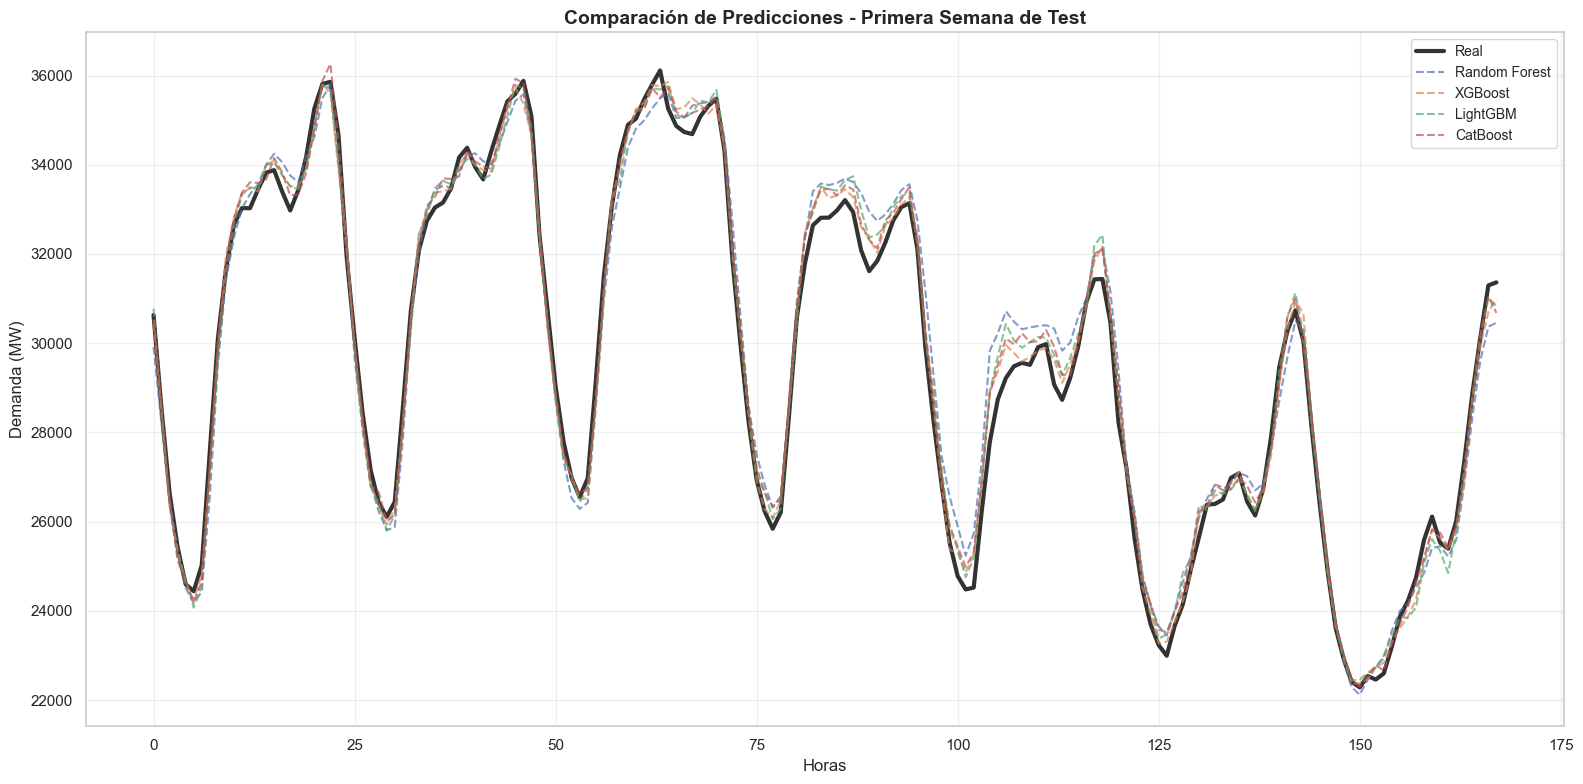

In [17]:
# Comparación visual de predicciones (primera semana)
plt.figure(figsize=(16, 8))
n_samples = 168  # Una semana

plt.plot(y_test[:n_samples].values, label='Real', linewidth=3, color='black', alpha=0.8)
plt.plot(rf_pred_test[:n_samples], label='Random Forest', linestyle='--', alpha=0.7)
plt.plot(xgb_pred_test[:n_samples], label='XGBoost', linestyle='--', alpha=0.7)
plt.plot(lgb_pred_test[:n_samples], label='LightGBM', linestyle='--', alpha=0.7)
plt.plot(cat_pred_test[:n_samples], label='CatBoost', linestyle='--', alpha=0.7)

plt.title('Comparación de Predicciones - Primera Semana de Test', fontsize=14, fontweight='bold')
plt.xlabel('Horas', fontsize=12)
plt.ylabel('Demanda (MW)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Guardar Modelos y Resultados

In [18]:
# Crear directorio para modelos
models_dir = Path('artifacts/trained_models')
models_dir.mkdir(parents=True, exist_ok=True)

# Guardar modelos
print("Guardando modelos entrenados...")
joblib.dump(rf_pipeline, models_dir / 'random_forest_pipeline.pkl')
print("  ✓ Random Forest")

joblib.dump(xgb_pipeline, models_dir / 'xgboost_pipeline.pkl')
print("  ✓ XGBoost")

joblib.dump(lgb_pipeline, models_dir / 'lightgbm_pipeline.pkl')
print("  ✓ LightGBM")

joblib.dump(cat_pipeline, models_dir / 'catboost_pipeline.pkl')
print("  ✓ CatBoost")

# Limpiar carpeta de logs de CatBoost
catboost_info_dir = Path('catboost_info')
if catboost_info_dir.exists():
    shutil.rmtree(catboost_info_dir)
    print("  ✓ Carpeta catboost_info eliminada")

# Guardar predicciones
predictions_dir = Path('artifacts/data/predictions')
predictions_dir.mkdir(parents=True, exist_ok=True)

# Crear DataFrame con todas las predicciones
predictions_df = pd.DataFrame({
    'datetime': df_test_clean['datetime'].values,
    'demanda_real': y_test.values,
    'pred_random_forest': rf_pred_test,
    'pred_xgboost': xgb_pred_test,
    'pred_lightgbm': lgb_pred_test,
    'pred_catboost': cat_pred_test
})

predictions_df.to_parquet(predictions_dir / 'tree_models_predictions.parquet')
print("\n✓ Predicciones guardadas")

# Guardar resultados
resultados_df.to_csv(models_dir / 'tree_models_results.csv', index=False)
print("✓ Resultados guardados")

# Guardar importancias de features
rf_importance.to_csv(models_dir / 'feature_importance_rf.csv', index=False)
xgb_importance.to_csv(models_dir / 'feature_importance_xgb.csv', index=False)
lgb_importance.to_csv(models_dir / 'feature_importance_lgb.csv', index=False)
cat_importance.to_csv(models_dir / 'feature_importance_cat.csv', index=False)
print("✓ Importancias de features guardadas")

print("\n" + "="*60)
print("MODELOS BASADOS EN ÁRBOLES - COMPLETADO")
print("="*60)
print(f"Todos los modelos entrenados y guardados en: {models_dir}")
print(f"Tiempo total de entrenamiento: {sum(resultados_df['tiempo_entrenamiento']):.2f}s")

Guardando modelos entrenados...
  ✓ Random Forest
  ✓ XGBoost
  ✓ LightGBM
  ✓ CatBoost
  ✓ Carpeta catboost_info eliminada

✓ Predicciones guardadas
✓ Resultados guardados
✓ Importancias de features guardadas

MODELOS BASADOS EN ÁRBOLES - COMPLETADO
Todos los modelos entrenados y guardados en: artifacts/trained_models
Tiempo total de entrenamiento: 2.96s
